In [1]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import importlib
from tqdm.notebook import tqdm
import time
import pandas as pd

from topostats.filters import Filters
from topostats.grains import Grains
from topostats.grainstats import GrainStats
from topostats.io import find_files, read_yaml, write_yaml, LoadScans
from topostats.logs.logs import setup_logger, LOGGER_NAME
from topostats.utils import update_config

In [4]:
import logging
logger = logging.getLogger(LOGGER_NAME)
logger.setLevel(logging.CRITICAL)

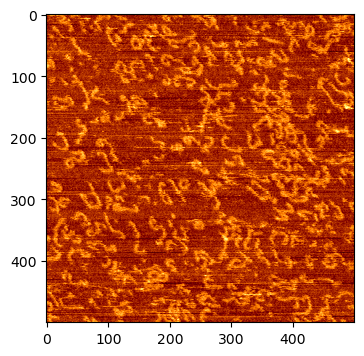

In [5]:
# Set BASE_DIR containing a file and config.yaml
BASE_DIR=Path(os.getcwd())
FILE_EXT = ".gwy"
IMG_KEY = "PL-Wavemode500"
CONFIG = "config_PL.yaml"
IMG_FILES = [BASE_DIR.joinpath('data').joinpath(IMG_KEY+".gwy"),]

config = read_yaml(BASE_DIR.joinpath('data').joinpath(CONFIG))

loading_config = config["loading"]
filter_config = config["filter"]
filter_config.pop("run")
grain_config = config["grains"]
grain_config.pop("run")
loaded_data = LoadScans(IMG_FILES, **config["loading"])
loaded_data.get_data()

# Plot the loaded scan in its raw format
fig, ax = plt.subplots(figsize=(4, 4))
# When Topostats loads .gwy file, aspect ratio of the image is in img_dict.
plt.imshow(loaded_data.image, cmap="afmhot", aspect=loaded_data.img_dict[IMG_KEY]["scale"]["xy_aspect"])
plt.show()

In [6]:
# Filter
filtered_image = Filters(
        image=loaded_data.img_dict[IMG_KEY]["image_original"],
        filename=loaded_data.img_dict[IMG_KEY]["img_path"],
        pixel_to_nm_scaling=loaded_data.img_dict[IMG_KEY]["pixel_to_nm_scaling"],
        **filter_config,)
filtered_image.filter_image()

Available NumPy arrays to plot in filter_image.images dictionary :

dict_keys(['pixels', 'initial_median_flatten', 'initial_tilt_removal', 'initial_quadratic_removal', 'initial_scar_removal', 'masked_median_flatten', 'masked_tilt_removal', 'masked_quadratic_removal', 'secondary_scar_removal', 'scar_mask', 'mask', 'zero_average_background', 'gaussian_filtered', 'initial_nonlinear_polynomial_removal', 'masked_nonlinear_polynomial_removal'])


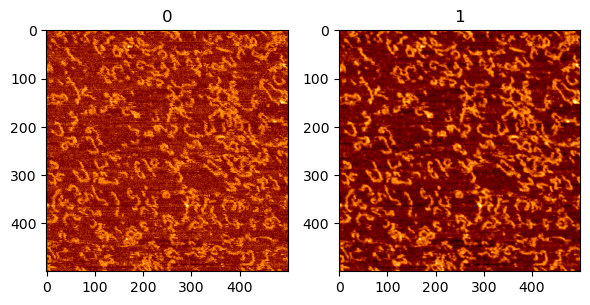

In [7]:
SHOW_TILE = True  # Set True to all images in the filtering result.
def tile_images(list_image, titles=[],figsize=6):
    cols = len(list_image)
    if cols>4:
        raise ValueError()
    fig, ax = plt.subplots(1,cols,figsize=(figsize,figsize))
    if len(titles)!=cols:
        titles = [str(i) for i in range(cols)]
    for col in range(cols):
        ax[col].set_title(titles[col])
        ax[col].imshow(list_image[col], cmap="afmhot")
    fig.tight_layout()
    plt.show()

if SHOW_TILE:
    print(f"Available NumPy arrays to plot in filter_image.images dictionary :\n\n{filtered_image.images.keys()}")

f_img = filtered_image.images
tile_images([f_img['zero_average_background'],f_img['gaussian_filtered']])

# Find grains

Here polymer chains are detected by using Grains of Topostats. Resulting Numpy array of "labelled_regions_02" conatins index label starting with 1 for all polymer chains. 

In [55]:
THRESHOLD_GRAIN = 1.0
grain_config["threshold_method"] = "std_dev"
grain_config["threshold_std_dev"]["above"] = THRESHOLD_GRAIN

grains = Grains(
                image=filtered_image.images["zero_average_background"],
                filename=filtered_image.filename,
                pixel_to_nm_scaling=filtered_image.pixel_to_nm_scaling,
                **grain_config,
                )
grains.find_grains()
labelled = grains.directions["above"]["labelled_regions_02"]

print(f"Resulting image keys above threshold:\n {grains.directions['above'].keys()}")

Resulting image keys above threshold:
 dict_keys(['mask_grains', 'labelled_regions_01', 'tidied_border', 'removed_noise', 'removed_small_objects', 'labelled_regions_02', 'coloured_regions'])


Resuting labelled image of polymer chains:
 count 2615, type <class 'numpy.ndarray'>, shape (500, 500)
Resuting labelled image of polymer chains:
 count 347, type <class 'numpy.ndarray'>, shape (500, 500)


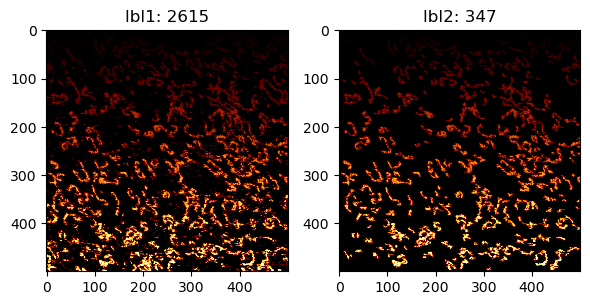

In [56]:
lbl1 = grains.directions['above']['labelled_regions_01']
print(f"Resuting labelled image of polymer chains:\n count {lbl1.max()}, type {type(lbl1)}, shape {lbl1.shape}")
lbl2 = grains.directions['above']['labelled_regions_02']
print(f"Resuting labelled image of polymer chains:\n count {lbl2.max()}, type {type(lbl2)}, shape {lbl2.shape}")
tile_images([lbl1,lbl2], titles=[f"lbl1: {lbl1.max()}",f"lbl2: {lbl2.max()}"])

# Line detection

Linemol module is for detection of linear part of polymer chain of SPM height data. Principle of this analysis is to score all possible lines in a molecule. The score is calculated from the sum of the height values of the pixels that make up the line.

This module has three classes to handle data processing.
- **`Line`** - contains pixel positions of a line
- **`Molecule`** - contains a molecule from preceding grain analysis
- **`LineDetection`** - tools to analyse linear part of molecules to generate results as Pandas.DataFrame

## Data import and filtering by Topostats
Topostats is a Python library for topological data analysis. It provides a set of tools for analyzing and visualizing topological data, such as persistent homology, persistent diagrams, and other related techniques. It is designed to be easy to use and extend, and is suitable for both research and educational purposes. Filtering and finding grains from a Gwyddion file are conducted by Topostats software program. 

## Molecule class
Pixels of each molecule are obtained from grains.directions["above"]["labelled_regions_02"]. A class of `LineDetection` handles the labelled regions ndarray. All molecules are stored as `Molecule` object that provide positions, vectors generated from the positions, methods for detection of linear part.

## Processing
Number of all possible vectors in a molecule sometimes comes enormous, so several steps are implemented to reduce unnecessary lines.

### Qudrants and length filtering
vector pairs are filtered by direction and length. The minimum and maximum length are defined as `min_len` and `max_len` in a config dict.
-  Exclude vectors from the set that are facing the third and fourth quadrants.
-  Exclude vectors exceeding provided minimum and maximum length

### Empty pixel(s) along a line
After collecting the set of vectors, a synthetic straight line is drawn in 2D binary array. When original binary data has gaps along the synthetic line, it is considered to have 'empty' pixels. A line with large number of empty pixels are excluded because it should not be regard as a straight and continuous line. The maximum pixel number is defined as `allowed_empty` in a config dict.

Resulting lines are stored as DataFrame of pandas. Initial dataframe has columns of `mol_idx`, `score`, `pix1`, `pix2`, `angle`

### Overlapping lines
(Not implemented yet) Some lines are covered with a longer line completely, others are covered partially. Shorter and lines with lower score that is covered with other line can be eliminated. In order to prioritize score, dataframe was sorted descending by `score` column.



In [57]:
# assuming linedetection.py is in parent directory of data 
#MOD_DIR=Path(os.getenv('REPO')).joinpath('line_detection')
#sys.path.append(MOD_DIR)
import linemol
importlib.reload(linemol)
from linemol import Molecule, LineDetection, Line

In [58]:
labelled = lbl2
source = filtered_image.images["gaussian_filtered"]

config = {"min_len":7, "max_len":20,"allowed_empty":0, "use_cache":True}

ld = LineDetection(labelled, source, **config)

In [59]:
count = 0
time0 = time.perf_counter()
for i in tqdm(range(len(ld.molecules))):
    mol = ld.molecules[i]
    filtered = ld.filter_by_length(mol)
    if filtered is not None:
        lines_cnt = ld.score_lines(mol, filtered)
        if lines_cnt > 0:
            count += 1
time1 = time.perf_counter()
duration = time1 - time0
print(f"{count} molecules calculated in {duration:.3f}")

  0%|          | 0/347 [00:00<?, ?it/s]

338 molecules calculated in 34.216


In [60]:
ld.line_cache_hit

(846602, 1193510)

### line cache results
-> error is large in the conditions of PC with small number of calculation.

With cache         Without cache
(13066/65984)
9.671s             10.346s
9.887s              9.691s
9.887s             10.138s
10.246s            10.524s
10.226s            10.151s


In [62]:
# Save as pickle
SAVE_FILE = False
prefix = f'{IMG_KEY}_{config["min_len"]}_{config["max_len"]}_{config["allowed_empty"]}_'
if SAVE_FILE:
    ld.score_df.to_pickle(prefix + "score_df.pkl.gz")
    ld.stat_df.to_pickle(prefix + "stat_df.pkl.gz")

In [63]:
# Result of line detection is in score_df
found_mol_count = len(ld.score_df.loc[ld.score_df["score"]>0].groupby("mol_idx").count())
print(f"{found_mol_count} molecules estimated (score > 0)")
maximum_length = ld.score_df.loc[ld.score_df["score"]>0]["length"].max()
print(f"Maximum length was {maximum_length:.2f}")
ld.score_df.loc[ld.score_df["score"]>0].sort_values("length", ascending=False)

285 molecules estimated (score > 0)
Maximum length was 20.00


,mol_idx,score,empty,x1,y1,x2,y2,length,angle,norm_score
8221,154,11.249044,0,5,3,25,3,20.0,0.000000,2.802861
1999,31,7.921159,0,8,10,20,26,20.0,53.130102,3.003019
7261,139,9.255641,0,3,3,23,3,20.0,0.000000,3.785276
7262,139,9.115969,0,0,3,20,3,20.0,0.000000,3.674092
13916,270,6.732876,0,2,3,18,15,20.0,36.869898,3.190965
...,...,...,...,...,...,...,...,...,...,...
7094,128,5.698497,0,5,8,12,8,7.0,0.000000,1.103609
7097,128,5.583538,0,4,8,11,8,7.0,0.000000,1.014003
16801,332,3.527334,0,5,0,5,7,7.0,90.000000,1.213751
13161,234,4.128968,0,19,8,26,8,7.0,0.000000,1.774124


In [64]:
# Filtering statistics is in stat_df
ld.stat_df.sort_values("len_filtered", ascending=True).head()

,mol_idx,pixels,total_vecs,len_filtered,total_lines,min_len,max_len,max_pix,score_cutoff
91,95,847,358281,0,NaN,7,20,500,NaN
215,220,556,154290,0,NaN,7,20,500,NaN
116,120,844,355746,0,NaN,7,20,500,NaN
103,107,20,190,1,NaN,7,20,500,NaN
145,149,20,190,1,NaN,7,20,500,NaN


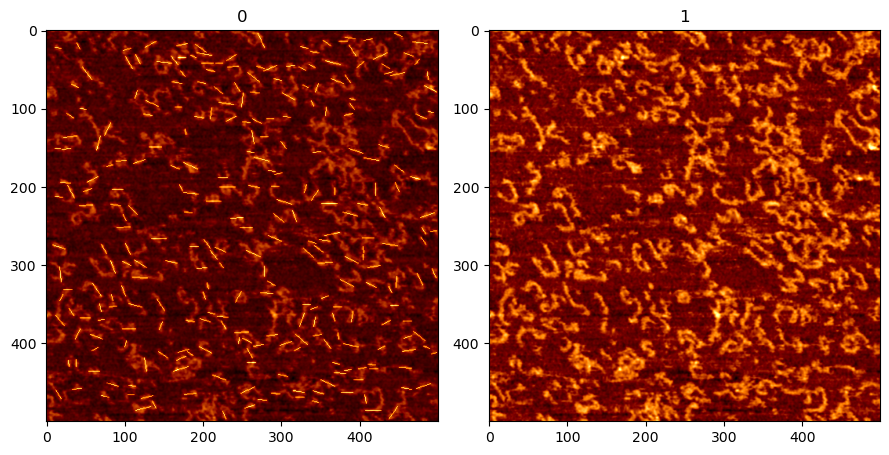

In [65]:
overlaid = ld.overlay_lines(num_lines=1, factor=200)
tile_images([overlaid, ld.source_img], figsize=9)

# Normalized score

This normalization should be conducted for each molecule.

<Axes: xlabel='angle', ylabel='norm_score'>

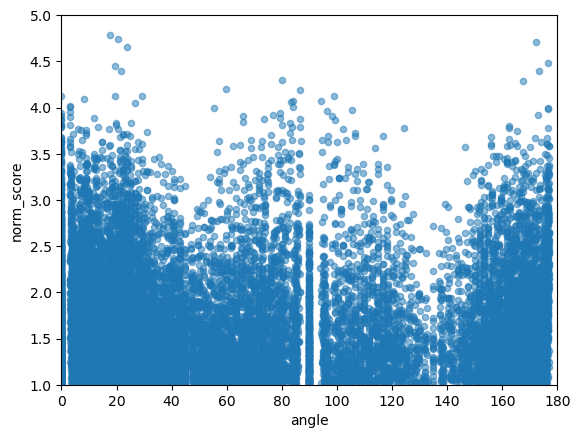

In [104]:
sorted_df = ld.score_df.sort_values("norm_score",ascending=False)
sorted_df[0:20000].plot.scatter(x="angle", y='norm_score', alpha=0.5, xlim=(0,180), ylim=(1,5))

<Axes: ylabel='Frequency'>

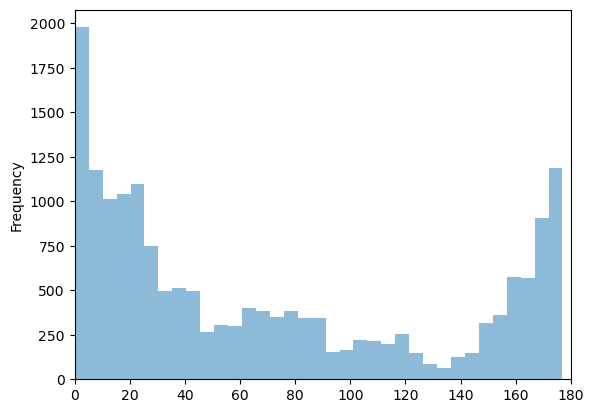

In [54]:
sorted_df[0:20000]["angle"].plot.hist(bins=35,alpha=0.5, xlim=(0,180))

# Checking an individual molecule

In [102]:
ld.score_df.loc[(ld.score_df["norm_score"]>2.0) & (ld.score_df["angle"] % 90 != 0)].sort_values("norm_score", ascending=False).sort_values("length",ascending=False)[100:200]

,mol_idx,score,empty,x1,y1,x2,y2,length,angle,norm_score
14655,286,7.843680,0,23,26,42,31,19.646883,14.743563,3.203821
1623,30,9.470641,0,5,3,24,8,19.646883,14.743563,2.676984
16871,343,9.234326,0,24,5,5,10,19.646883,165.256437,3.748074
4807,116,9.380955,0,19,11,38,16,19.646883,14.743563,3.355509
1629,30,9.317463,0,4,3,23,8,19.646883,14.743563,2.580879
...,...,...,...,...,...,...,...,...,...,...
11840,205,7.728520,0,13,6,16,25,19.235384,81.027373,3.523766
5830,123,9.049828,0,2,1,19,10,19.235384,27.897271,3.041785
4299,105,8.215818,0,32,13,15,22,19.235384,152.102729,3.217874
14254,277,6.965608,0,2,12,19,21,19.235384,27.897271,3.216730


In [68]:
def plot_emphasized_by_score(df, mol, ilocs, use_max=False):
    """ Plot an emphasized line in src image"""
    mol_score = df.loc[df["mol_idx"]==mol.mol_idx]
    if len(mol_score)==0:
        return
    line_mask = mol.get_blank()
    for iloc in ilocs:
        row = mol_score.iloc[iloc].tolist()
        (x1,y1,x2,y2) = tuple(row[3:7])
        l = Line.create_from_pos(x1,y1,x2,y2).get_mask(mol.height, mol.width)
        line_mask = line_mask + l
    line_mask = line_mask / (len(ilocs))
    emp = ld.get_emphasized(mol,line_mask,factor=1.5, use_max=True)
    plt.imshow(emp)
    plt.plot()


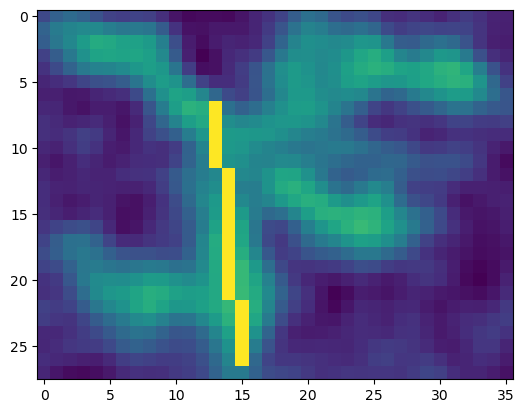

In [103]:
mol_idx = 205
mol = ld.molecules[mol_idx - 1]
mol_df = ld.score_df.loc[(ld.score_df["mol_idx"]==mol.mol_idx)].sort_values("norm_score",ascending=False)
plot_emphasized_by_score(mol_df, mol,range(0,1))

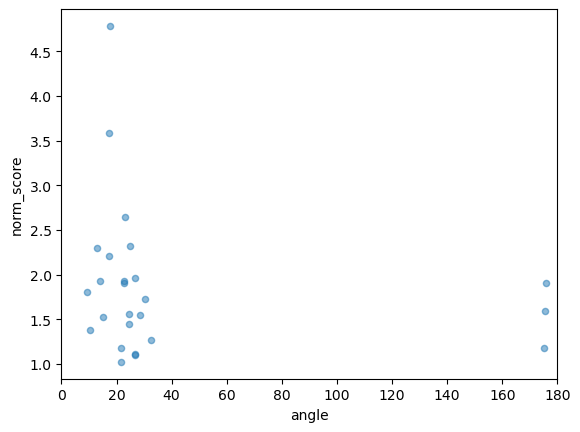

In [100]:
ret_mol = mol_df[:].plot.scatter(x="angle", y='norm_score', alpha=0.5, xlim=(0,180))

<AxesSubplot:ylabel='Frequency'>

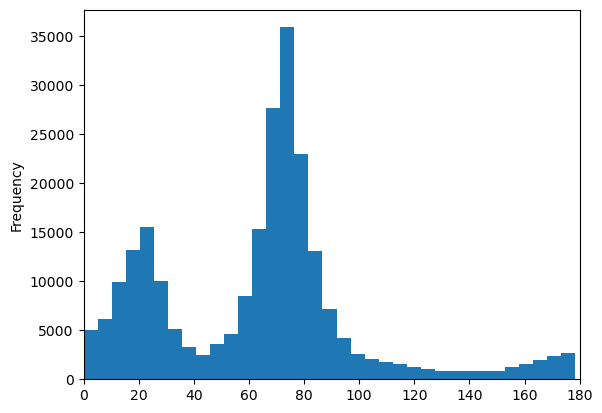

In [45]:

ld.score_df["angle"].plot.hist(bins=35, xlim=(0,180))


In [433]:
score100_df = pd.read_pickle("PO-Wavemode500_7_100_0_score_df.pkl.gz")

In [439]:
score100_df["length"].max()

61.68468205316454

In [459]:
sorted_df = score100_df.sort_values("norm_score",ascending=False)
sorted_130 = sorted_df.loc[(sorted_df["angle"]>125) & (sorted_df["angle"]<140)]
sorted_130.groupby("mol_idx").median()
#.plot.scatter(x="angle", y='norm_score', alpha=0.5, xlim=(0,180))

,score,length,angle,norm_score
mol_idx,,,,
21,1.370754,9.219544,130.601295,1.381840
70,4.315226,17.204651,127.862909,1.127443
81,4.222809,17.204651,125.537678,1.029909
100,2.429571,11.721674,133.120722,1.060446
115,4.281845,13.907070,126.448636,1.058874
152,5.253302,22.022716,128.290163,1.262899
171,4.685311,19.209373,130.236358,1.265892
172,6.004577,20.518285,138.576334,1.128281
201,3.628175,12.384758,131.633539,1.335046
